# 绘制土地利用类型（下垫面分布）
---
*@author: Evan*\
*@date: 2023-03-12*

[参考网址: 使用python绘制wrf中的土地利用类型](https://mp.weixin.qq.com/s/9tZlOh0eqbRUzKLHhVT4xw)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from netCDF4 import Dataset

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
import shapely.geometry as sgeom
from copy import copy
from wrf import to_np, getvar,get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords

In [3]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [4]:
def LU_MODIS21(uniq=np.arange(1, 22)):
    inds = uniq-1
    C = np.array([
    [0,.4,0],          #  1 Evergreen Needleleaf Forest
    [0,.4,.2],         #  2 Evergreen Broadleaf Forest
    [.2,.8,.2],        #  3 Deciduous Needleleaf Forest
    [.2,.8,.4],        #  4 Deciduous Broadleaf Forest
    [.2,.6,.2],        #  5 Mixed Forests
    [.3,.7,0],         #  6 Closed Shrublands
    [.82,.41,.12],     #  7 Open Shurblands
    [.74,.71,.41],     #  8 Woody Savannas
    [1,.84,.0],        #  9 Savannas
    [0,1,0],           #  10 Grasslands
    [0,1,1],           #  11 Permanant Wetlands
    [1,1,0],           #  12 Croplands
    [1,0,0],           #  13 Urban and Built-up
    [.7,.9,.3],        #  14 Cropland/Natual Vegation Mosaic
    [1,1,1],           #  15 Snow and Ice
    [.914,.914,.7],    #  16 Barren or Sparsely Vegetated
    [.5,.7,1],         #  17 Water (like oceans)
    [.86,.08,.23],     #  18 Wooded Tundra
    [.97,.5,.31],      #  19 Mixed Tundra
    [.91,.59,.48],     #  20 Barren Tundra
    [0,0,.88]])        #  21 Lake

    cm = ListedColormap(C[inds])

    labels = ['Evergreen Needleleaf Forest',
            'Evergreen Broadleaf Forest',
            'Deciduous Needleleaf Forest',
            'Deciduous Broadleaf Forest',
            'Mixed Forests',
            'Closed Shrublands',
            'Open Shrublands',
            'Woody Savannas',
            'Savannas',
            'Grasslands',
            'Permanent Wetlands',
            'Croplands',
            'Urban and Built-Up',
            'Cropland/Natural Vegetation Mosaic',
            'Snow and Ice',
            'Barren or Sparsely Vegetated',
            'Water',
            'Wooded Tundra',
            'Mixed Tundra',
            'Barren Tundra',
            'Lake']

    return cm, np.array(labels)[inds]

def ld1(landuse):
    # type 1:
    cm, labels = LU_MODIS21()
    ticks = [x+1.5 for x in range(len(labels))]

    n_max = len(labels)
    return to_np(landuse), ticks, labels, cm, n_max

def start(file_in, shp_path):
    ncfile = Dataset(file_in)
    landuse = getvar(ncfile, 'LU_INDEX')
    lats, lons = latlon_coords(landuse)
    cart_proj = get_cartopy(landuse)

    # Create a figure
    fig = plt.figure(figsize=(12,8))

    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=cart_proj)

    # Use the data extent
    ax.set_xlim(cartopy_xlim(landuse))
    ax.set_ylim(cartopy_ylim(landuse))

    # # Plot data
    landuse_new, ticks, labels, cm, n_max = ld1(landuse)

    im = ax.pcolormesh(to_np(lons), to_np(lats), landuse_new, vmin=1, vmax=n_max+1,
                    cmap=cm, alpha=0.8, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_ticks(ticks)
    cbar.ax.set_yticklabels(labels)

    # Add the gridlines
    ax.gridlines(color="black", linestyle="dotted")

    # add xticks and yticks
    xticks = list(np.arange(70, 140, 2))
    yticks = list(np.arange(0, 60, 2))
    fig.canvas.draw()
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)
    # ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,linewidth=0)

    # 叠加shp
    ax.add_geometries(Reader(shp_path).geometries(), ccrs.PlateCarree(), lw=1.2, facecolor='none')

    # Set the labelsize
    plt.tick_params(labelsize=12)

    # Add title
    title = 'LU_Default'

    pic_name = r'D:/Download/landuse.png'
    plt.title(title, fontsize=15)
    fig.savefig(pic_name, bbox_inches='tight', dpi=600)
    plt.show()


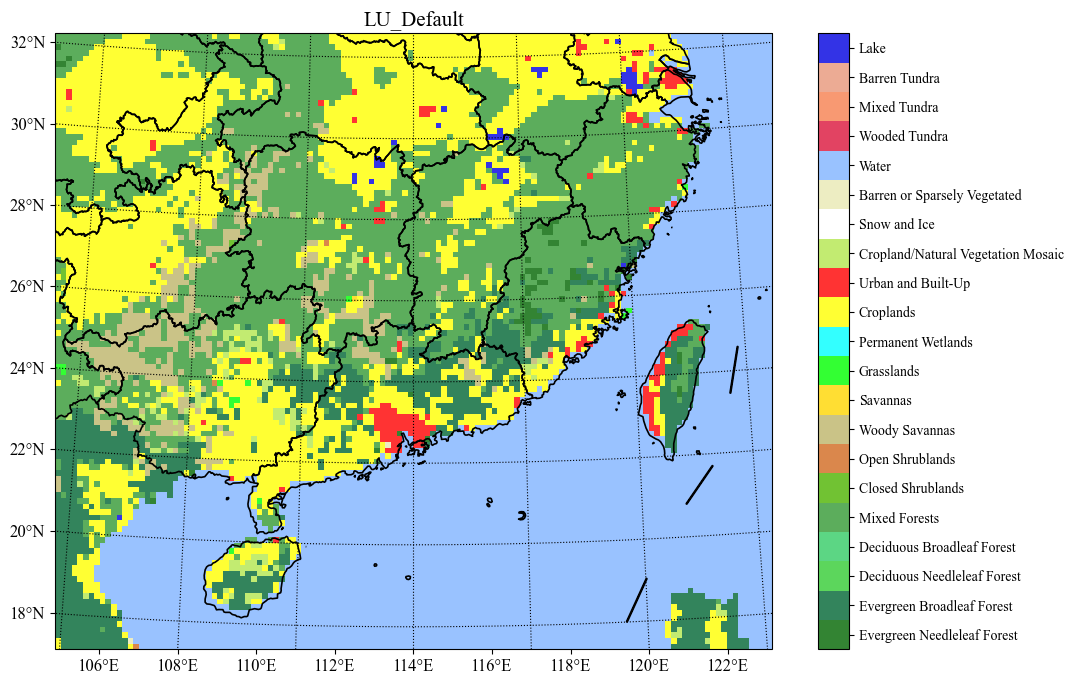

In [6]:
def main():
    file_in = './geo_em.d01.nc'
    shp_path ='./shapefile/china.shp'
    start(file_in, shp_path)

if __name__ == '__main__':
    main()